In [3]:
import nltk
import string
import re
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Load 20 Newsgroups dataset (use 'all' for full dataset or 'train'/'test' for subsets)
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
targets = newsgroups.target

# Define stopwords
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    cleaned = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned)

# Apply preprocessing (for demo, limit to first 100 documents)
cleaned_texts = [preprocess(doc) for doc in texts[:100]]

# Display a sample
print("Original:\n", texts[0][:300], "\n")
print("Cleaned:\n", cleaned_texts[0][:300])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original:
 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
 

Cleaned:
 sure bashers pens fans pretty confused lack kind posts recent pens massacre devils actually bit puzzled bit relieved however going put end nonpittsburghers relief bit praise pens man killing devils worse thought jagr showed much better regular season stats also lot fo fun watch playoffs bowman let j


In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

# Assuming `cleaned_texts` is your list of preprocessed documents

# 1. Bag of Words
bow_vectorizer = CountVectorizer(max_features=1000)
X_bow = bow_vectorizer.fit_transform(cleaned_texts)

print("Bag of Words shape:", X_bow.shape)

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_texts)

print("TF-IDF shape:", X_tfidf.shape)


Bag of Words shape: (100, 1000)
TF-IDF shape: (100, 1000)


In [6]:
import os

# Define the path to the GloVe file
glove_file = "glove.6B.100d.txt"

# Check if the file already exists, if not, download it
if not os.path.exists(glove_file):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip
    !rm glove.6B.zip

--2025-07-07 00:40:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-07 00:40:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-07 00:40:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
# Load GloVe embeddings (example path)
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

# Average word embeddings for each document
def get_avg_embedding(doc):
    words = doc.split()
    valid_vectors = [embedding_index[word] for word in words if word in embedding_index]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(100)

X_embed = np.array([get_avg_embedding(doc) for doc in cleaned_texts])

print("Embeddings shape:", X_embed.shape)


Loaded 400000 word vectors from GloVe.
Embeddings shape: (100, 100)


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Apply K-Means
k = 10  # You can change this
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

# Evaluation
sil_score = silhouette_score(X_tfidf, kmeans_labels)
print(f"Silhouette Score (TF-IDF + KMeans, k={k}): {sil_score:.4f}")


Silhouette Score (TF-IDF + KMeans, k=10): -0.0022


In [9]:
# Get feature names
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\nTop words per cluster:")
for i in range(k):
    print(f"Cluster {i}: ", end='')
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(", ".join(top_terms))



Top words per cluster:
Cluster 0: government, deleted, turkey, independent, private, cross, david, blue, way, served
Cluster 1: distribution, use, irq, comes, enough, tolerance, question, low, article, send
Cluster 2: started, another, may, amiga, acetone, one, original, mek, support, time
Cluster 3: anyone, bus, card, vmode, vesa, pro, email, local, eisa, ati
Cluster 4: etc, server, thanks, looking, anybody, address, years, last, year, looked
Cluster 5: system, channel, sound, one, bob, use, iisi, know, pens, using
Cluster 6: speed, run, believe, one, would, nice, components, apps, qualcomm, drive
Cluster 7: would, dont, rear, seem, kaan, time, detectors, radar, get, kryptonite
Cluster 8: either, even, used, app, blood, basketball, schools, school, sec, title
Cluster 9: history, law, say, light, dave, sabbath, put, oilers, example, points


In [10]:
# Apply KMeans on averaged GloVe embeddings
kmeans_embed = KMeans(n_clusters=k, random_state=42)
kmeans_embed_labels = kmeans_embed.fit_predict(X_embed)

# Evaluate
sil_embed = silhouette_score(X_embed, kmeans_embed_labels)
print(f"Silhouette Score (Word Embeddings + KMeans, k={k}): {sil_embed:.4f}")


Silhouette Score (Word Embeddings + KMeans, k=10): 0.0205


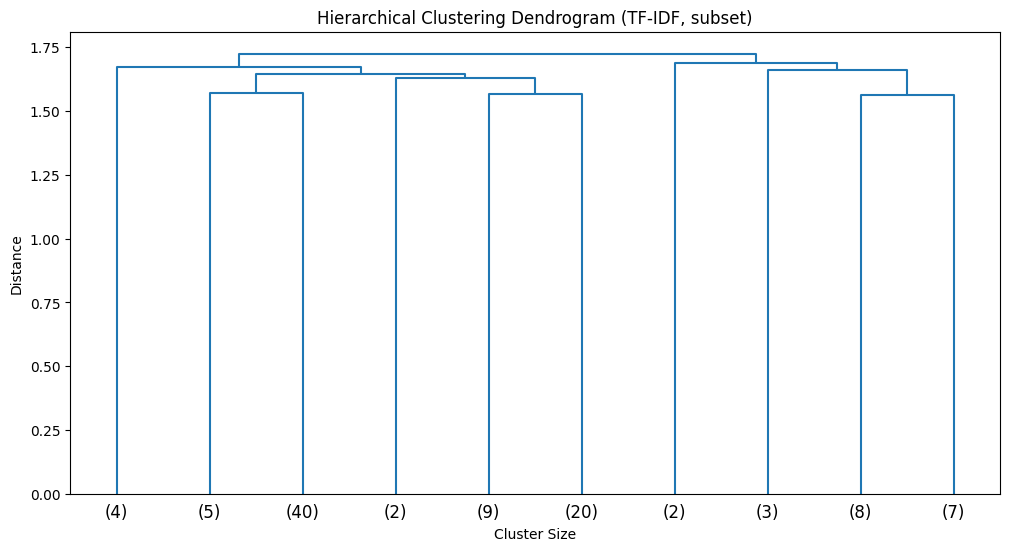

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Hierarchical clustering on first 100 documents
subset = X_tfidf[:100].toarray()

linkage_matrix = linkage(subset, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=10)
plt.title("Hierarchical Clustering Dendrogram (TF-IDF, subset)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()


In [12]:
#  Step 1: Preprocess & Train on Initial Data

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re, string

# Load dataset (for training)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
texts_train = newsgroups_train.data[:2000]  # Use 2000 docs for speed

# Simple preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    words = text.split()
    stopwords = set([
        'the', 'is', 'in', 'it', 'of', 'and', 'to', 'a', 'for', 'on', 'that', 'this',
        'with', 'as', 'are', 'was', 'at', 'by', 'an', 'be', 'have', 'from', 'or',
        'but', 'not', 'you', 'they', 'we', 'can', 'all', 'has', 'will', 'if', 'about'
    ])
    return ' '.join([w for w in words if w.isalpha() and w not in stopwords])

texts_train_clean = [preprocess(text) for text in texts_train]

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(texts_train_clean)

# KMeans clustering
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
train_labels = kmeans.fit_predict(X_train_tfidf)

# Evaluate
sil_score_train = silhouette_score(X_train_tfidf, train_labels)
print(f"Silhouette Score (train, k={k}): {sil_score_train:.4f}")


Silhouette Score (train, k=10): -0.0298


In [13]:
# Step 2: Prepare Unseen Test Documents

# Load test dataset (unseen docs)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
texts_test = newsgroups_test.data[:5]  # Test on 5 documents
texts_test_clean = [preprocess(text) for text in texts_test]

# Transform using previously fitted vectorizer
X_test_tfidf = vectorizer.transform(texts_test_clean)

# Predict clusters for new docs
predicted_clusters = kmeans.predict(X_test_tfidf)

# Output predictions
for i, (doc, cluster) in enumerate(zip(texts_test, predicted_clusters)):
    print(f"\nDoc {i+1} assigned to Cluster {cluster}")
    print(doc[:300], "\n---")



Doc 1 assigned to Cluster 2
I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can 
---

Doc 2 assigned to Cluster 2
I'm not familiar at all with the format of these "X-Face:" thingies, but
after seeing them in some folks' headers, I've *got* to *see* them (and
maybe make one of my own)!

I've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")
and I've managed to compile [un]compface too... but 
---

Doc 3 assigned to Cluster 2

In a word, yes.
 
---

Doc 4 assigned to Cluster 2

They were attacking the Iraqis to drive them out of Kuwait,
a country whose citizens have close blood and business ties
to Saudi citizens.  And me thinks if the US had not helped out
the Iraqis would have swallowed Saudi Arabia, too (or at 
least t

In [14]:
# Step 3: Evaluate Fit (Distance to Centroids)

# Show distances from new docs to all cluster centroids
distances = kmeans.transform(X_test_tfidf)

for i, dist in enumerate(distances):
    print(f"\nDoc {i+1} distances to centroids:")
    for j, d in enumerate(dist):
        print(f"  Cluster {j}: {d:.4f}")



Doc 1 distances to centroids:
  Cluster 0: 1.3988
  Cluster 1: 1.3855
  Cluster 2: 0.9735
  Cluster 3: 1.2439
  Cluster 4: 1.3347
  Cluster 5: 1.2944
  Cluster 6: 1.3170
  Cluster 7: 1.3923
  Cluster 8: 1.3545
  Cluster 9: 1.4142

Doc 2 distances to centroids:
  Cluster 0: 1.4000
  Cluster 1: 1.3479
  Cluster 2: 0.9506
  Cluster 3: 1.3948
  Cluster 4: 1.3137
  Cluster 5: 1.3617
  Cluster 6: 1.3209
  Cluster 7: 1.4049
  Cluster 8: 1.2819
  Cluster 9: 1.3945

Doc 3 distances to centroids:
  Cluster 0: 1.4142
  Cluster 1: 1.4142
  Cluster 2: 1.0131
  Cluster 3: 1.4142
  Cluster 4: 1.3347
  Cluster 5: 1.4142
  Cluster 6: 1.3209
  Cluster 7: 1.4142
  Cluster 8: 1.4142
  Cluster 9: 1.4142

Doc 4 distances to centroids:
  Cluster 0: 1.3329
  Cluster 1: 1.2347
  Cluster 2: 0.9291
  Cluster 3: 1.3920
  Cluster 4: 1.2950
  Cluster 5: 1.2781
  Cluster 6: 1.3106
  Cluster 7: 1.4032
  Cluster 8: 1.2963
  Cluster 9: 1.2671

Doc 5 distances to centroids:
  Cluster 0: 1.4142
  Cluster 1: 1.3778
  Clu

In [15]:
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top)}")

Cluster 0: armenians, turkish, event, supported, family, policy, members, million, thank, period
Cluster 1: government, press, must, public, based, people, vs, search, since, exist
Cluster 2: my, would, there, your, any, what, me, do, he, one
Cluster 3: heard, true, recently, chip, interesting, hi, own, same, goes, gods
Cluster 4: must, laws, so, groups, some, live, back, such, why, system
Cluster 5: book, remember, come, true, his, he, people, wrote, half, bought
Cluster 6: period, pp, play, third, power, second, no, first, red, st
Cluster 7: parts, line, also, supply, worth, driver, cost, wont, guess, available
Cluster 8: anyone, me, help, email, any, used, please, very, could, does
Cluster 9: religious, rights, his, going, genocide, washington, dc, who, clinton, bill
